# Scanpy: Quality control

# Get data

In this tutorial, we will run all tutorials with a set of 6 PBMC 10x datasets from 3 covid-19 patients and 3 healthy controls, the samples have been subsampled to 1500 cells per sample. They are part of the github repo and if you have cloned the repo they should be available in folder: `labs/data/covid_data_GSE149689`. Instructions on how to download them can also be found in the Precourse material. 


In [1]:
# create a data directory.
!mkdir -p data/raw



With data in place, now we can start loading libraries we will use in this tutorial.


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# gives error!! sc.logging.print_versions()


In [3]:
sc.settings.set_figure_params(dpi=80)

We can first load the data individually by reading directly from HDF5 file format (.h5). 


In [4]:
data_cov1 = sc.read_10x_h5('./data/raw/nCoV_PBMC_1.h5')
data_cov1.var_names_make_unique()
data_cov15 = sc.read_10x_h5('./data/raw/nCoV_PBMC_15.h5')
data_cov15.var_names_make_unique()
data_cov17 = sc.read_10x_h5('./data/raw/nCoV_PBMC_17.h5')
data_cov17.var_names_make_unique()
data_ctrl5 = sc.read_10x_h5('./data/raw/Normal_PBMC_5.h5')
data_ctrl5.var_names_make_unique()
data_ctrl13 = sc.read_10x_h5('./data/raw/Normal_PBMC_13.h5')
data_ctrl13.var_names_make_unique()
data_ctrl14 = sc.read_10x_h5('./data/raw/Normal_PBMC_14.h5')
data_ctrl14.var_names_make_unique()

reading ./data/raw/nCoV_PBMC_1.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/nCoV_PBMC_15.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/nCoV_PBMC_17.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_13.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_14.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Create one merged object


In [5]:
# add some metadata
data_cov1.obs['type']="Covid"
data_cov1.obs['sample']="covid_1"
data_cov15.obs['type']="Covid"
data_cov15.obs['sample']="covid_15"
data_cov17.obs['type']="Covid"
data_cov17.obs['sample']="covid_17"
data_ctrl5.obs['type']="Ctrl"
data_ctrl5.obs['sample']="ctrl_5"
data_ctrl13.obs['type']="Ctrl"
data_ctrl13.obs['sample']="ctrl_13"
data_ctrl14.obs['type']="Ctrl"
data_ctrl14.obs['sample']="ctrl_14"


# merge into one object.
adata = data_cov1.concatenate(data_cov15, data_cov17, data_ctrl5, data_ctrl13, data_ctrl14)

# and delete individual datasets to save space
del(data_cov1, data_cov15, data_cov17)
del(data_ctrl5, data_ctrl13, data_ctrl14)



 You can print a summary of the datasets in the Scanpy object, or a summary of the whole object.


In [6]:
print(adata.obs['sample'].value_counts())

adata

covid_17    1500
ctrl_5      1500
covid_1     1500
ctrl_13     1500
ctrl_14     1500
covid_15    1500
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

# Calculate QC

Having the data in a suitable format, we can start calculating some quality metrics. We can for example calculate the percentage of mitocondrial and ribosomal genes per cell and add to the metadata. This will be helpfull to visualize them across different metadata parameteres (i.e. datasetID and chemistry version). There are several ways of doing this, and here manually calculate the proportion of mitochondrial reads and add to the metadata table.

Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017): "High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane."

 First, let Scanpy calculate some general qc-stats for genes and cells with the function `sc.pp.calculate_qc_metrics`, similar to `calculateQCmetrics` in Scater. It can also calculate proportion of counts for specific gene populations, so first we need to define which genes are mitochondrial, ribosomal and hemoglogin.


In [7]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

,gene_ids,feature_types,genome,mt,ribo,hb
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False
...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,False,False
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,False,False
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,False,False
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,False,False


In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)


 Now you can see that we have additional data in the scanpy `obs` slot.


In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1



 Now you can see that we have additional data in the scanpy `obs` slot.


In [10]:
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Plot QC

Now we can plot some of the QC-features as violin plots.


... storing 'type' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg

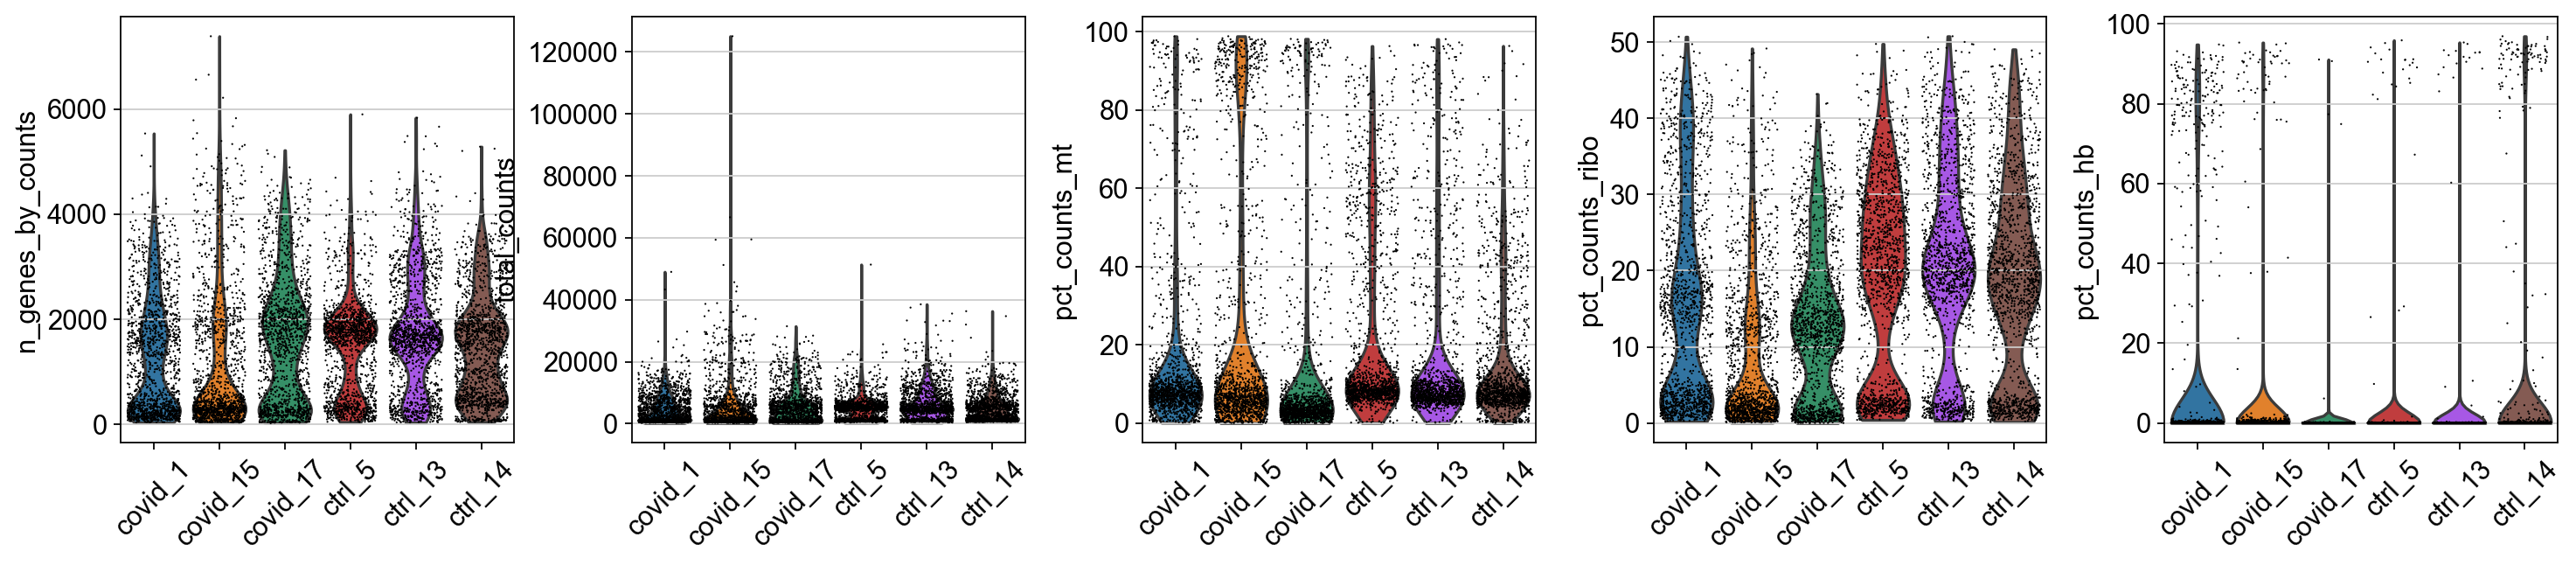

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

As you can see, there is quite some difference in quality for the 4 datasets, with for instance the covid_15 sample having fewer cells with many detected genes and more mitochondrial content. As the ribosomal proteins are highly expressed they will make up a larger proportion of the transcriptional landscape when fewer of the lowly expressed genes are detected. And we can plot the different QC-measures as scatter plots.


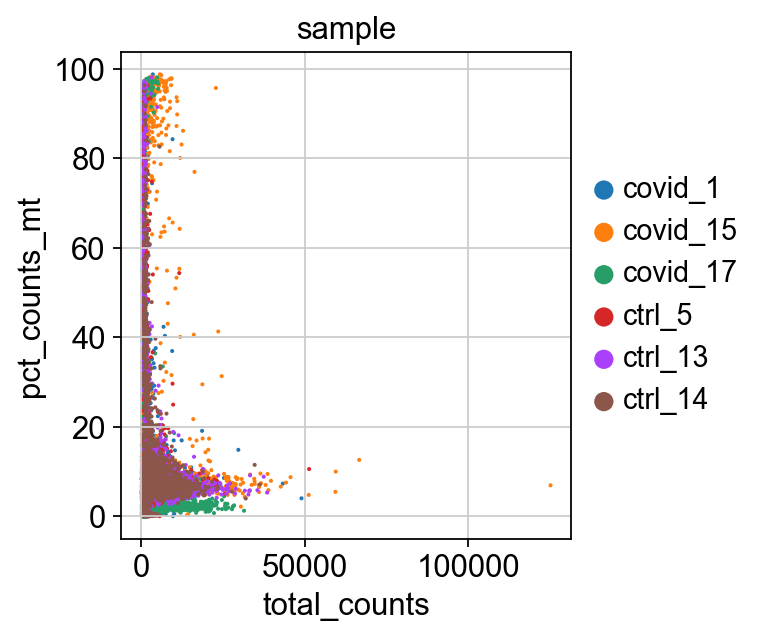

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")


### TASK: Plot scatterplots
Plot additional QC stats that we have calculated as scatter plots. How are the different measures correlated? Can you explain why?


# Filtering

A standard approach is to filter cells with low amount of reads as well as genes that are present in at least a certain amount of cells. Here we will only consider cells with at least 200 detected genes and genes need to be expressed in at least 3 cells. Please note that those values are highly dependent on the library preparation method used.


In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 1021 cells that have less than 200 genes expressed
filtered out 14760 genes that are detected in less than 3 cells
7979 18778


 Extremely high number of detected genes could indicate doublets. However, depending on the cell type composition in your sample, you may have cells with higher number of genes (and also higher counts) from one cell type. <br>In these datasets, there is also a clear difference between the v2 vs v3 10x chemistry with regards to gene detection, so it may not be fair to apply the same cutoffs to all of them. Also, in the protein assay data there is a lot of cells with few detected genes giving a bimodal distribution. This type of distribution is not seen in the other 2 datasets. Considering that they are all PBMC datasets it makes sense to regard this distribution as low quality libraries. Filter the cells with high gene detection (putative doublets) with cutoffs 4100 for v3 chemistry and 2000 for v2. <br>Here, we will filter the cells with low gene detection (low quality libraries) with less than 1000 genes for v2 and < 500 for v2.


In [14]:
# filter for gene detection for v2
#keep_v2 = (adata.obs['n_genes_by_counts'] < 2000) & (adata.obs['n_genes_by_counts'] > 500) & (adata.obs['lib_prep'] == 'v2')
#print(sum(keep_v2))

# filter for gene detection for v3
#keep_v3 = (adata.obs['n_genes_by_counts'] < 4100) & (adata.obs['n_genes_by_counts'] > 1000) & (adata.obs['lib_prep'] != 'v2')
#print(sum(keep_v3))

# keep both sets of cells
#keep = (keep_v2) | (keep_v3)
#print(sum(keep))
#adata = adata[keep, :]

#print("Remaining cells %d"%adata.n_obs)

Additionally, we can also see which genes contribute the most to such reads. We can for instance plot the percentage of counts per gene.


normalizing counts per cell
    finished (0:00:00)


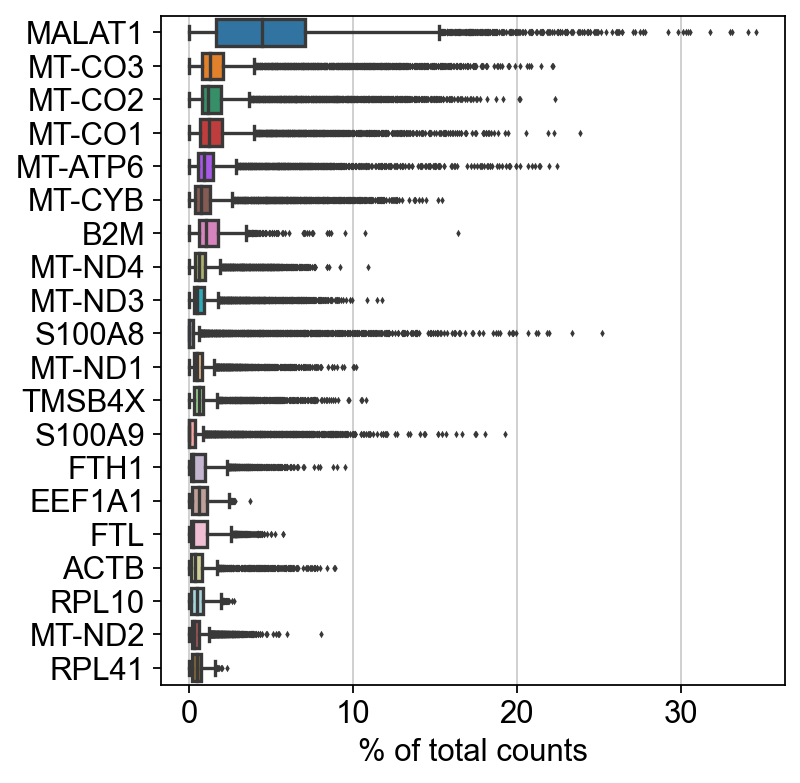

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20)

As you can see, MALAT1 constitutes up to 30% of the UMIs from a single cell and the other top genes are mitochondrial and ribosomal genes. It is quite common that nuclear lincRNAs have correlation with quality and mitochondrial reads, so high detection of MALAT1 may be a technical issue. Let us assemble some information about such genes, which are important for quality control and downstream filtering.

## Mito/Ribo filtering

We also have quite a lot of cells with high proportion of mitochondrial and low proportion ofribosomal reads. It could be wise to remove those cells, if we have enough cells left after filtering. <br>Another option would be to either remove all mitochondrial reads from the dataset and hope that the remaining genes still have enough biological signal. <br>A third option would be to just regress out the `percent_mito` variable during scaling. In this case we had as much as 99.7% mitochondrial reads in some of the cells, so it is quite unlikely that there is much cell type signature left in those. <br>Looking at the plots, make reasonable decisions on where to draw the cutoff. In this case, the bulk of the cells are below 20% mitochondrial reads and that will be used as a cutoff. We will also remove cells with less than 5% ribosomal reads. 


In [16]:
# filter for percent mito


adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 5762


 As you can see, a large proportion of sample covid_15 is filtered out. Also, there is still quite a lot of variation in `percent_mito`, so it will have to be dealt with in the data analysis step. We can also notice that the `percent_ribo` are also highly variable, but that is expected since different cell types have different proportions of ribosomal content, according to their function.

## Plot filtered QC

Lets plot the same QC-stats another time.


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

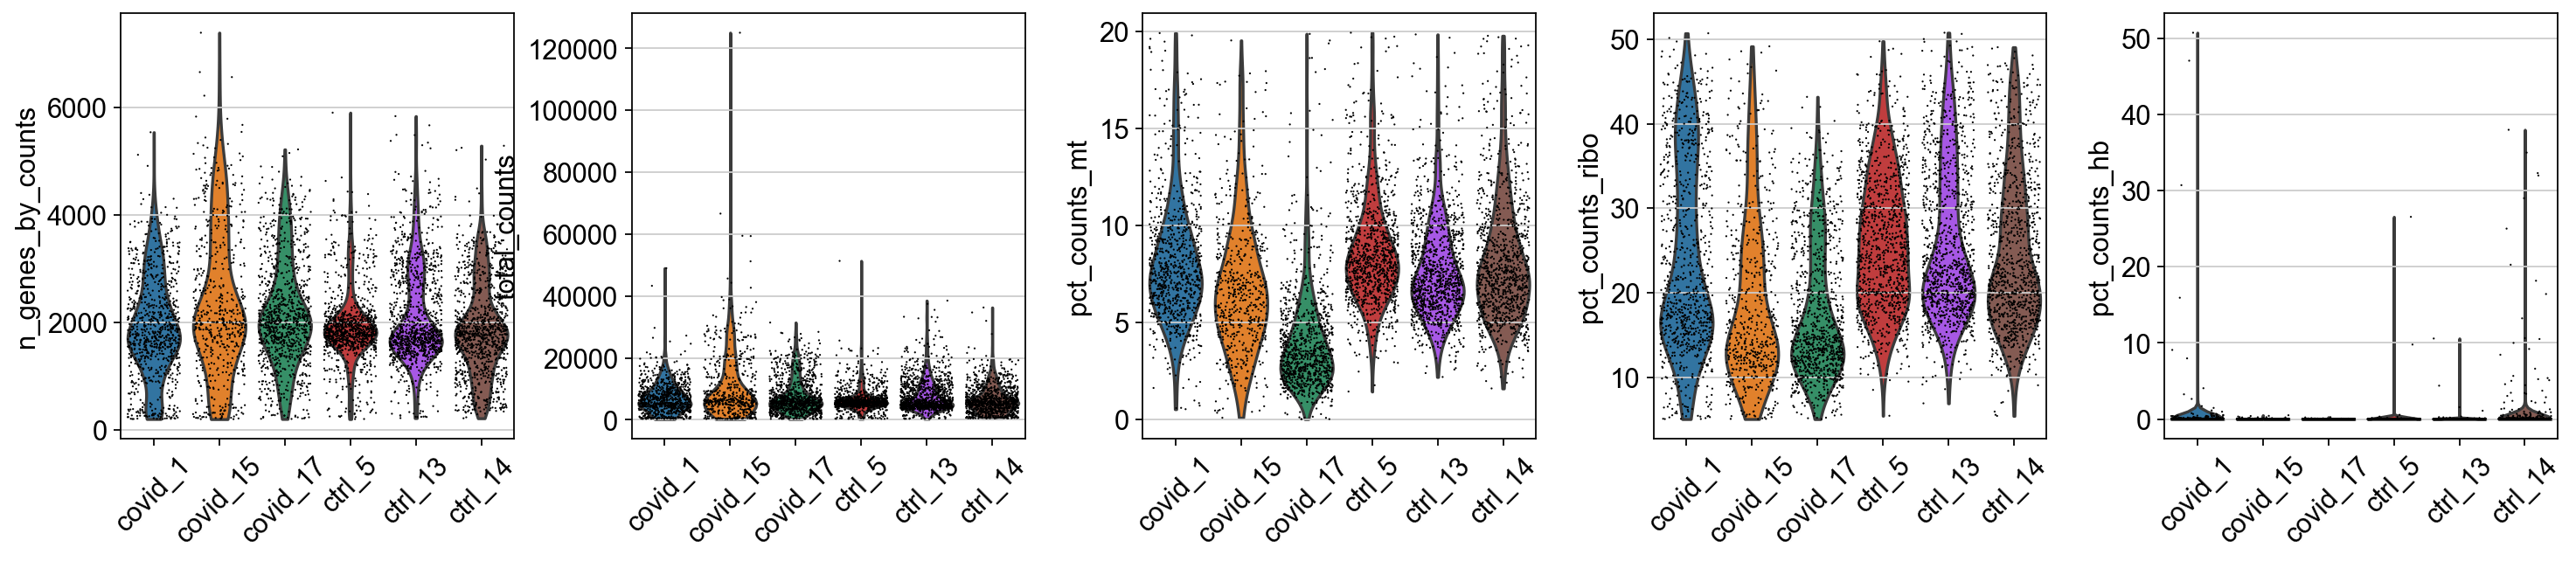

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation = 45)

## Filter genes

As the level of expression of mitochondrial and MALAT1 genes are judged as mainly technical, and hemoglobin genes mainly from RBC contamination, it can be wise to remove them from the dataset bofore any further analysis. 


In [18]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

5762 18752


# Calculate cell-cycle scores

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at [RegevLab Github repo](https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt).


In [19]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi
    

In [20]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


 Before running cell cycle we have to normalize the data. In the scanpy object, the data slot will be overwritten with the normalized data. So first, save the raw data into the slot `raw`.  <br><br>Then run normalization, logarimize and scale the data. 


In [21]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.


In [22]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    729 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    772 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


We can now plot a violin plot for the cell cycle scores as well.


... storing 'phase' as categorical
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

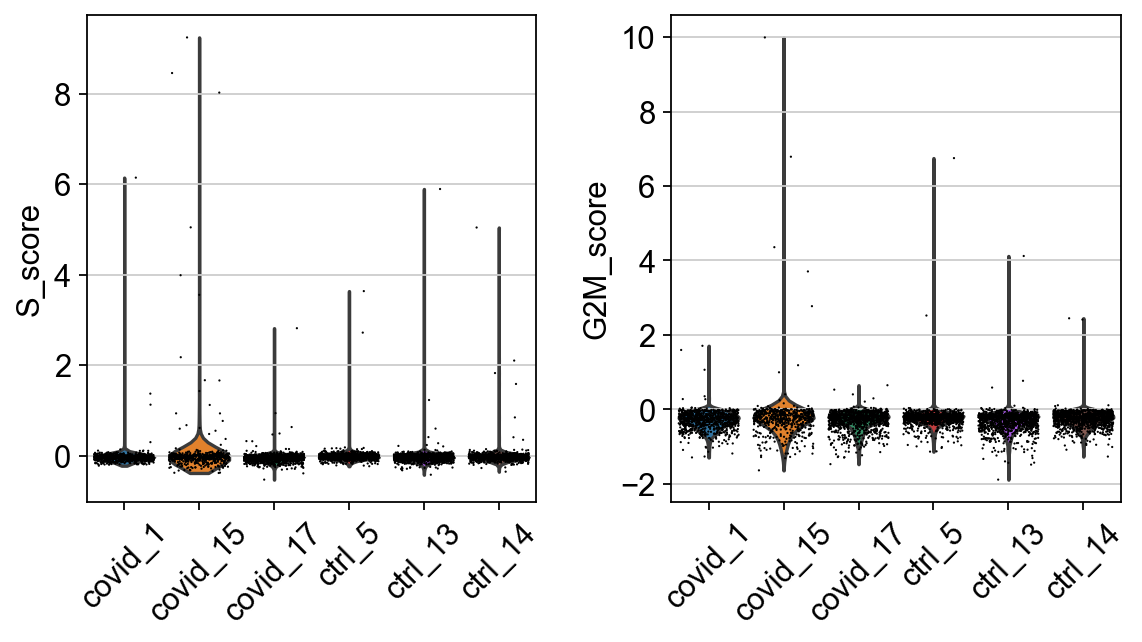

In [23]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'sample', rotation=45)

In this case it looks like we only have a few cycling cells in the datasets.

# Predict doublets

Doublets/Mulitples of cells in the same well/droplet is a common issue in scRNAseq protocols. Especially in droplet-based methods whith overloading of cells. In a typical 10x experiment the proportion of doublets is linearly dependent on the amount of loaded cells. As  indicated from the Chromium user guide, doublet rates are about as follows:
![](../../figs/10x_doublet_rate.png)
Most doublet detectors simulates doublets by merging cell counts and predicts doublets as cells that have similar embeddings as the simulated doublets. Most such packages need an assumption about the number/proportion of expected doublets in the dataset. The data you are using is subsampled, but the orignial datasets contained about 5 000 cells per sample, hence we can assume that they loaded about 9 000 cells and should have a doublet rate at about 4%.
OBS! Ideally doublet prediction should be run on each sample separately, especially if your different samples have different proportions of celltypes. In this case, the data is subsampled so we have very few cells per sample and all samples are sorted PBMCs so it is okay to run them together. 

For doublet detection, we will use the package `Scrublet`, so first we need to get the raw counts from `adata.raw.X` and run scrublet with that matrix. Then we add in the doublet prediction info into our anndata object.


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 44.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 5.1 seconds


168

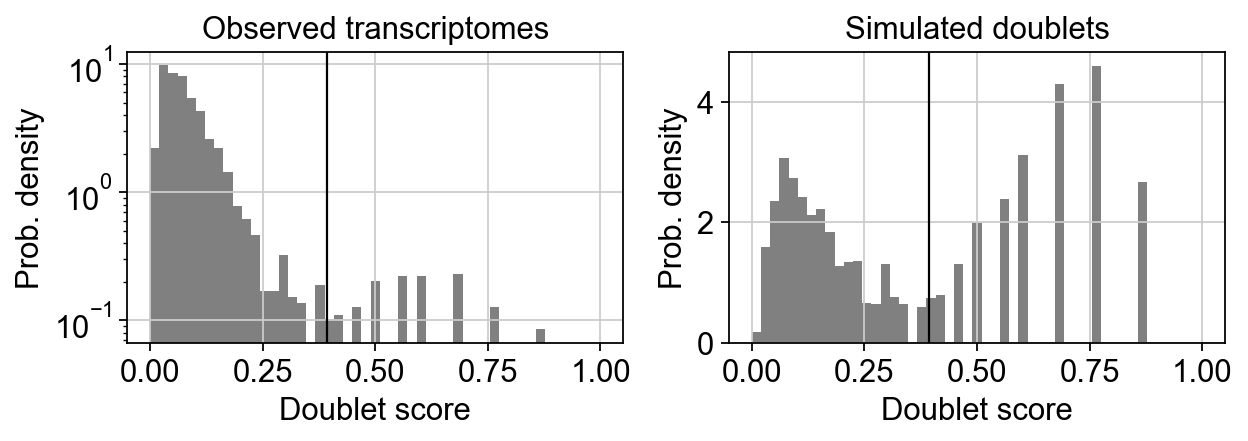

In [24]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])


In [25]:
# add in column with singlet/doublet instead of True/False

adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

We should expect that two cells have more detected genes than a single cell, lets check if our predicted doublets also have more detected genes in general.


... storing 'doublet_info' as categorical
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


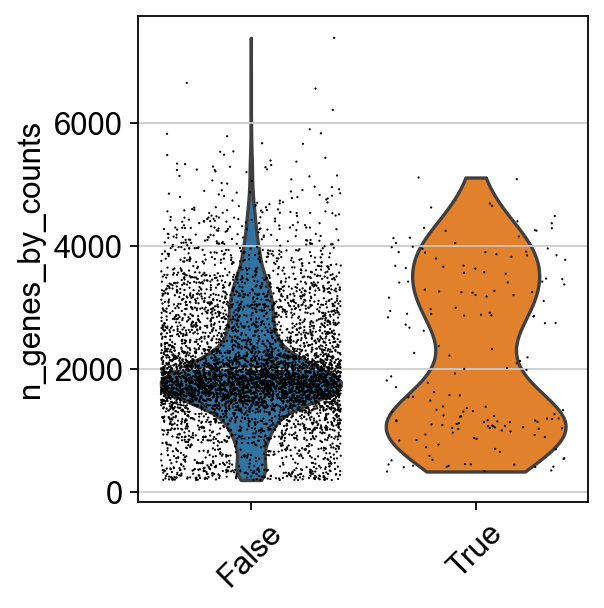

In [26]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

Now, lets run PCA and UMAP and plot doublet scores onto umap to check the doublet predictions. 


In [27]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

extracting highly variable genes


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:240: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values


    finished (0:00:13)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


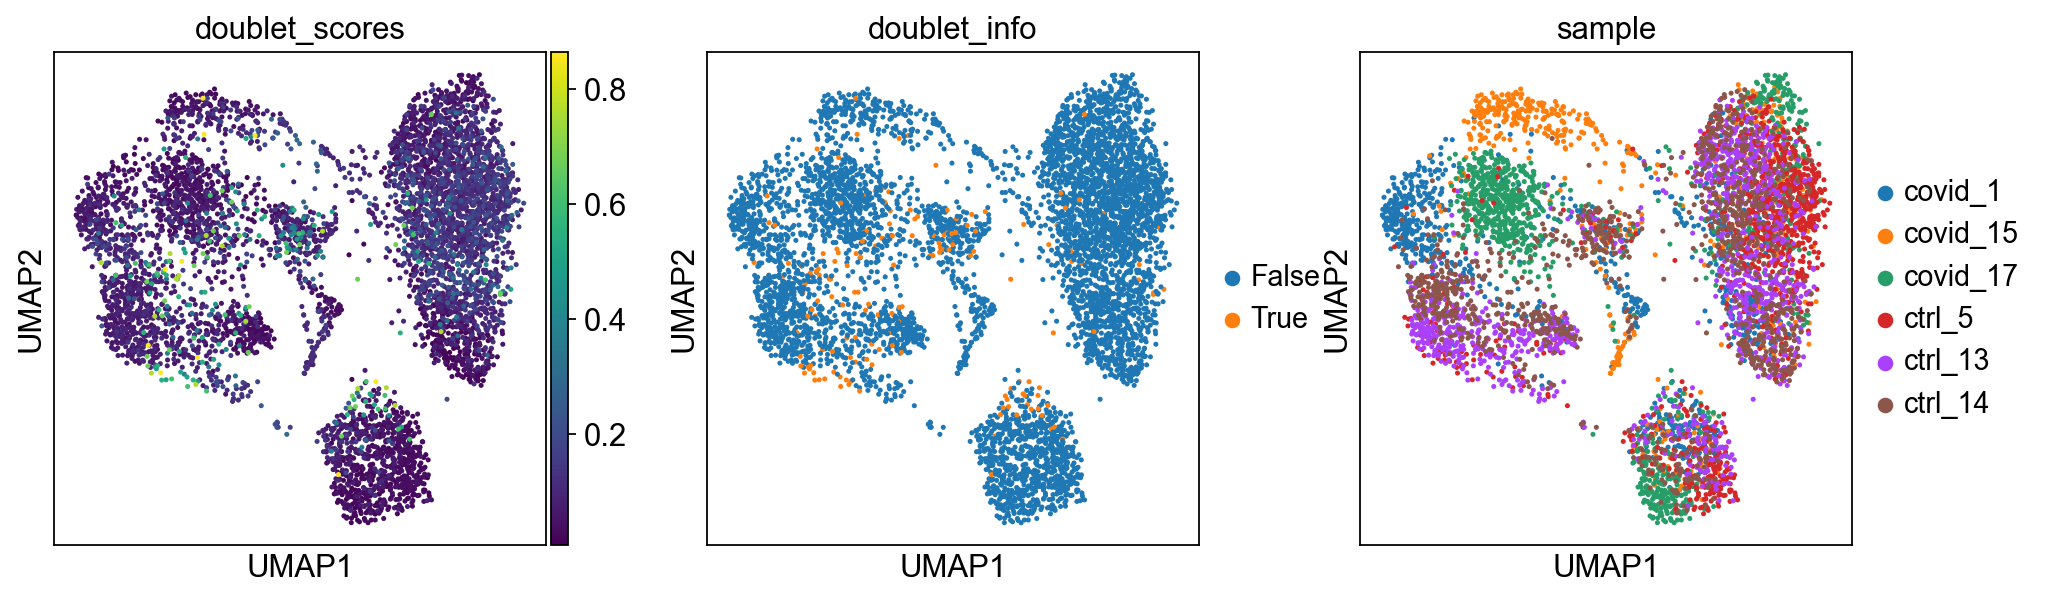

In [28]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info','sample'])


Now, lets remove all predicted doublets from our data.


In [29]:
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)


(5594, 18752)


# Save data
Finally, lets save the QC-filtered data for further analysis. Create output directory `results` and save data to that folder.


In [30]:
import os
os.makedirs('data/results/', exist_ok=True)

save_file = 'data/results/scanpy_qc_filtered_covid.h5ad'
adata.write_h5ad(save_file)